# EDA

In [1]:
import pandas as pd
import json
from tqdm import tqdm
from json import JSONDecodeError
import pickle

tqdm.pandas()
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200 # DPI 고화질로 향상
plt.rcParams['font.family'] = 'NanumGothic'
import seaborn as sns

from mpire import WorkerPool
import multiprocessing
n_cpu = multiprocessing.cpu_count()
from itertools import chain
import glob
from natsort import natsorted
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

from kiwipiepy import Kiwi
kiwi = Kiwi(model_type='sbg')

from collections import Counter
from itertools import chain

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim import corpora, models
from gensim.utils import simple_preprocess

In [3]:
target = pd.read_excel('./final_simple_stat.xlsx')
target = target[target['inclusion']==1].reset_index(drop=True)
target_idx = target[target['inclusion']==1]['idx'].tolist()
target_idx.remove(398) #398.json 파일 없음
target_idx.remove(506) #506.json 파일 없음
len(target_idx)

255

In [7]:
target['title_p/n'].value_counts(normalize=True)

title_p/n
-1.0    0.677043
 0.0    0.210117
 1.0    0.112840
Name: proportion, dtype: float64

In [8]:
target['e_policy_p/n'].value_counts(normalize=True)

e_policy_p/n
-1.0    0.579767
 1.0    0.233463
 0.0    0.186770
Name: proportion, dtype: float64

### Demographic

In [15]:
# demo_keys = ['title','gender_ratio','age_ratio']
def get_article_demo(idx):
    # demo_list = []
    res = {}
    res['idx'] = idx
    with open(f'./news_json_files/{idx}.json',encoding='utf-8-sig') as f:
        json_object = json.load(f)
    res['title'] = json_object['title']
    res['gender_ratio'] = json_object['gender_ratio']
    res['age_ratio'] = json_object['age_ratio']
    del json_object
    # demo_list.append(res)
    return res

In [16]:
get_article_demo(289)

{'idx': 289,
 'title': '"돈 쥐고 서민 고통 외면하는 기재부 해체" 공공운수노조 \'공공성 강화\' 총궐기',
 'gender_ratio': {'남자': '34', '여자': '66'},
 'age_ratio': {'10대': '0',
  '20대': '8',
  '30대': '34',
  '40대': '42',
  '50대': '14',
  '60대 이상': '2'}}

In [26]:
with WorkerPool(n_jobs=n_cpu-1) as pool:
    article_demo = pool.map(get_article_demo, target_idx, progress_bar=True)

100%|██████████| 255/255 [00:42<00:00,  1.30it/s]


In [27]:
test = pd.DataFrame(article_demo)
test

,idx,title,gender_ratio,age_ratio
0,0,"文 ""원전, 60년 주력 전원…신한울 1·2호기 이른시간 내 가동""(종합2보)","{'남자': '86', '여자': '14'}","{'10대': '0', '20대': '3', '30대': '12', '40대': '..."
1,2,원전 확대·4대강사업 계승…MB 시절 사회갈등 되풀이하나,"{'남자': '75', '여자': '25'}","{'10대': '0', '20대': '4', '30대': '15', '40대': '..."
2,3,與 “원자력 소외된 아픔 드린 것 사과”… 원전 전문가도 영입,"{'남자': '86', '여자': '14'}","{'10대': '0', '20대': '2', '30대': '9', '40대': '2..."
3,5,"탈원전에 3~5년 늦어진 원전… 文대통령, 이제와서 “조기가동”","{'남자': '84', '여자': '16'}","{'10대': '0', '20대': '2', '30대': '13', '40대': '..."
4,7,헝가리 이어 체코 정상도…문대통령 앞에서 연이은 원전발언,"{'남자': '86', '여자': '14'}","{'10대': '0', '20대': '4', '30대': '20', '40대': '..."
...,...,...,...,...
250,499,"[취재파일] '원전 정책 뒤집기'?…원전, 현실적 한계와 가능성",{},{}
251,501,이제야 '탈원전 족쇄' 푸는 정부…원전 수명 다시 늘린다,{},{}
252,503,"이재명 ""2040년 내연차 판매중단""…탄소세도 공식화",{},{}
253,504,"文대통령 ""韓 수소경제 빠르게 성장...세계최고 수준 기술""",{},{}


In [28]:
pd.json_normalize(test['age_ratio'])

,10대,20대,30대,40대,50대,60대 이상
0,0,3,12,25,32,28
1,0,4,15,35,32,15
2,0,2,9,22,33,33
3,0,2,13,31,32,21
4,0,4,20,35,27,15
...,...,...,...,...,...,...
250,NaN,NaN,NaN,NaN,NaN,NaN
251,NaN,NaN,NaN,NaN,NaN,NaN
252,NaN,NaN,NaN,NaN,NaN,NaN
253,NaN,NaN,NaN,NaN,NaN,NaN


### 유저 이력

In [2]:
#  {'user_id': 'zVxY',
#   'nickname': 'c00l****',
#   'user_real_nickname': '얼레',
#   'start_date': '2021.11.28.',
#   'sum_reply': '1',
#   'sum_son_reply': '0',
#   'sum_emotion': '0',
#   'recent_n_reply': '0',
#   'recent_n_deleted': '0',
#   'recent_n_emotion': '0',
#   'recent_rate_emotion': '0%',
#   'recent_rate_self_delete': '0%'}

profile_keys =['user_id','nickname','user_real_nickname','start_date','sum_reply','sum_son_reply','sum_emotion','recent_n_reply','recent_n_deleted','recent_n_emotion','recent_rate_emotion','recent_rate_self_delete']
def get_user_profile(idx):
    user_dic_profile = []
    with open(f'./news_json_files/{idx}.json',encoding='utf-8-sig') as f:
        json_object = json.load(f)
    res_list = [d['dic_history'] for d in json_object['dic_reply']]
    del json_object
    for res in res_list:
        if type(res)==dict:
            user_dic_profile.append({key: res[key] for key in profile_keys})
    del res_list, res
    return user_dic_profile

In [ ]:
with WorkerPool(n_jobs=n_cpu-1) as pool:
    user_profile = pool.map(get_user_profile, target_idx, progress_bar=True)

100%|██████████| 255/255 [07:23<00:00,  3.07s/it]


In [ ]:
user_profile_df = pd.DataFrame(list(chain(*user_profile)))
user_profile_df = user_profile_df.drop_duplicates().reset_index(drop=True)
user_profile_df['total_reply'] = user_profile_df['sum_reply'].str.replace(',','').astype(int) + user_profile_df['sum_son_reply'].str.replace(',','').astype(int)
user_profile_df['sum_emotion'] = user_profile_df['sum_emotion'].str.replace(',','').astype(int)

In [8]:
# 평균 + 1sd
heavy_cut = user_profile_df['total_reply'].mean() + user_profile_df['total_reply'].std()
heavy_cut

9313.231634772319

In [9]:
user_profile_df.loc[user_profile_df['total_reply'] > heavy_cut,'heavy'] = 1
user_profile_df.loc[user_profile_df['total_reply'] <= heavy_cut,'heavy'] = 0
user_profile_df['heavy'].value_counts(normalize=True)

heavy
0.0    0.887944
1.0    0.112056
Name: proportion, dtype: float64

In [18]:
# user_profile_df.to_pickle('./user_profile_df.pkl')
# user_profile_df.to_csv('./user_profile_df.csv', index=None)

In [10]:
user_profile_df = pd.read_pickle('./user_profile_df.pkl')
user_profile_df

,user_id,nickname,user_real_nickname,start_date,sum_reply,sum_son_reply,sum_emotion,recent_n_reply,recent_n_deleted,recent_n_emotion,recent_rate_emotion,recent_rate_self_delete,total_reply,heavy
0,NXIM,myls****,mylse1028,2006.08.25.,"1,462",311,11356,9,0,23,56%,0%,1773,0.0
1,2Mh8r,chun****,뭉치,2006.04.21.,"1,686",118,15530,76,22,93,49%,29%,1804,0.0
2,81WDL,hoeu****,쿠쿠쿠리,2016.04.10.,3,0,525,0,0,0,0%,0%,3,0.0
3,vHmK,livi****,unseen,2017.08.27.,"2,669",75,25747,35,17,104,85%,49%,2744,0.0
4,2lvoK,inyj****,연짱버디,2006.11.03.,"1,756",110,8982,62,0,"1,087",91%,0%,1866,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44437,1HfFX,kata****,행복여행,2006.06.27.,"13,723",69,98204,18,0,146,88%,0%,13792,1.0
44438,2vgvO,kswb****,ksw,2007.04.01.,"7,048",417,43742,187,2,563,78%,1%,7465,0.0
44439,EbqI,pota****,pot,2020.01.23.,"1,908",81,5410,3,0,1,100%,0%,1989,0.0
44440,PAXV,kkhb****,소언다문,2019.02.19.,"1,265",63,2941,5,0,20,95%,0%,1328,0.0


In [15]:
user_profile_df['start_date'] = pd.to_datetime(user_profile_df['start_date'])

In [16]:
user_profile_df['start_date']

0       2006-08-25
1       2006-04-21
2       2016-04-10
3       2017-08-27
4       2006-11-03
           ...    
44437   2006-06-27
44438   2007-04-01
44439   2020-01-23
44440   2019-02-19
44441   2013-06-18
Name: start_date, Length: 44442, dtype: datetime64[ns]

In [11]:
# heavy vs normal user list
# hvy_users = user_profile_df.loc[user_profile_df['heavy']==1,'user_id'].tolist()
# nor_users = user_profile_df.loc[user_profile_df['heavy']==0,'user_id'].tolist()

##### User 클러스터링

In [4]:
# 클러스터링 결과 확인
# user_profile_df = pd.read_csv('./user_profile_with_clusters.csv')
# hvy_users = user_profile_df.loc[user_profile_df['updated_cluster_label']==1,'user_id'].tolist()
# nor_users = user_profile_df.loc[user_profile_df['updated_cluster_label']==0,'user_id'].tolist()
user_profile_df = pd.read_csv('./user_profile_with_clusters_v2.csv')
user_profile_df['user_type'].value_counts(normalize=True)

user_type
normal    0.838801
heavy     0.161199
Name: proportion, dtype: float64

In [5]:
hvy_users = user_profile_df.loc[user_profile_df['user_type']=='heavy','user_id'].tolist()
nor_users = user_profile_df.loc[user_profile_df['user_type']=='normal','user_id'].tolist()

In [6]:
user_profile_df['user_id'].nunique()

37389

/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

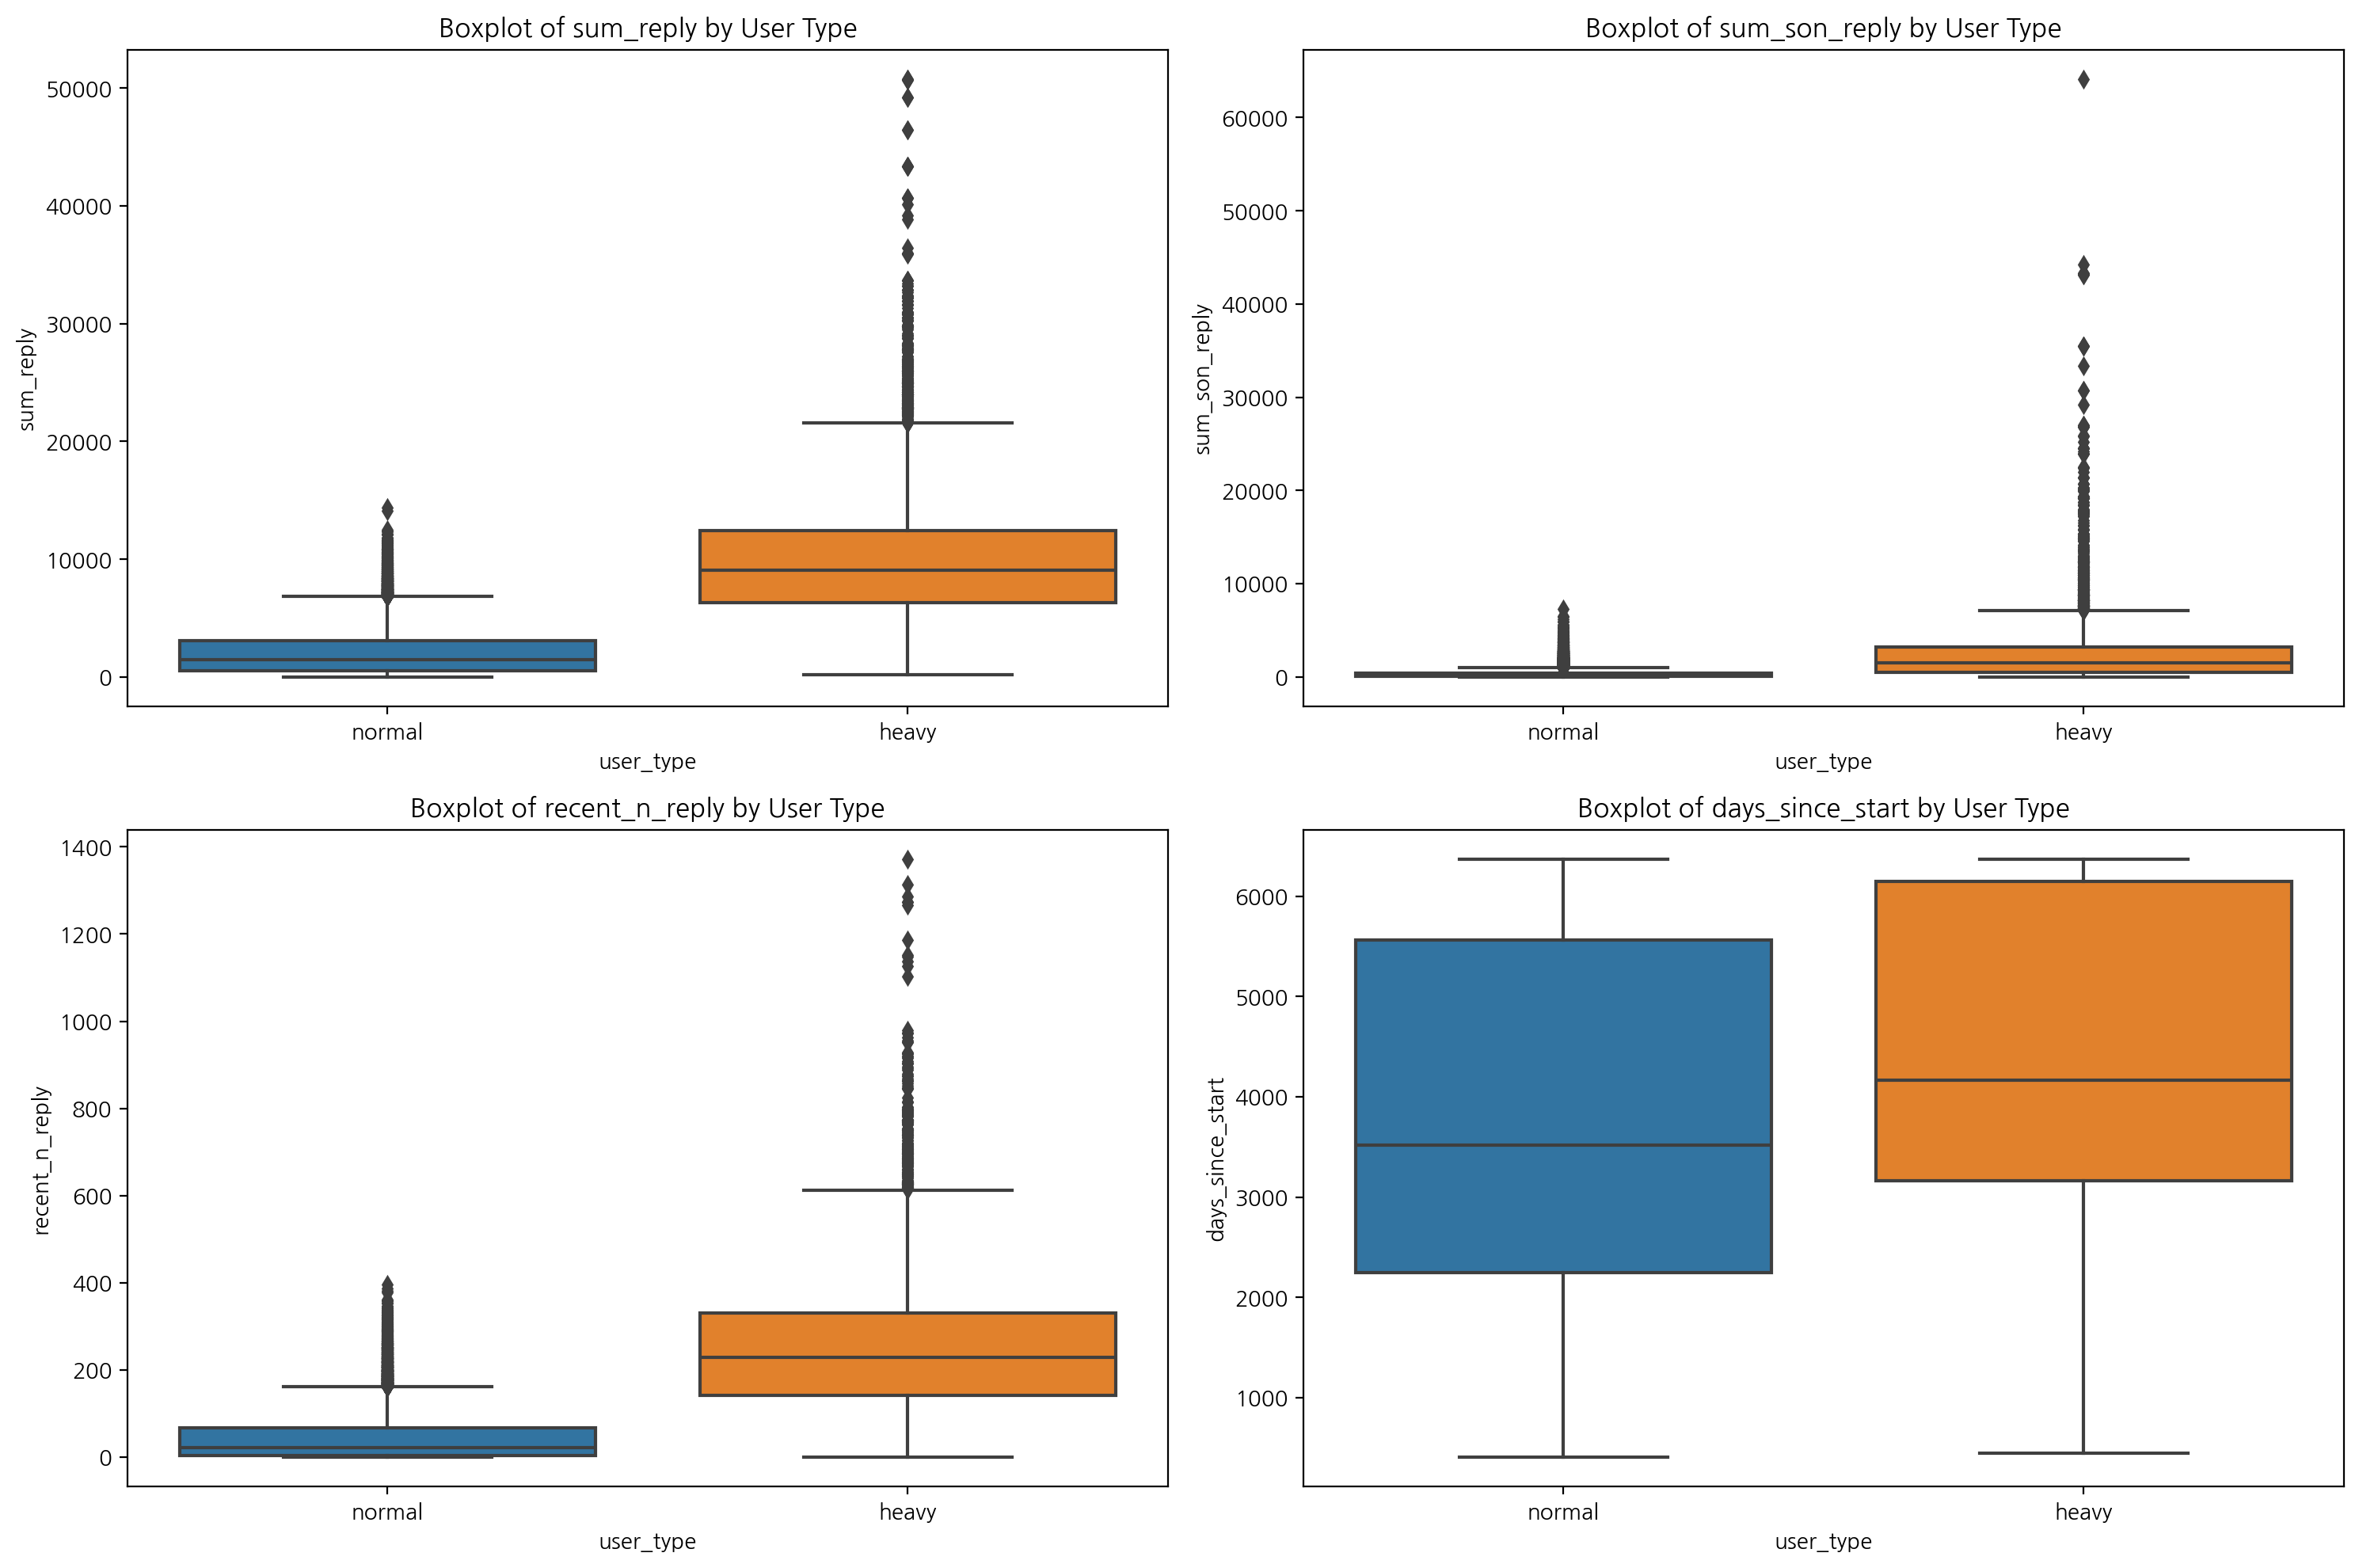

In [7]:
# Summary statistics for each user type
selected_features = ['sum_reply', 'sum_son_reply', 'recent_n_reply', 'days_since_start']
summary_stats = user_profile_df.groupby('user_type')[selected_features].describe()

# Visualizations
plt.figure(figsize=(15, 10))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='user_type', y=feature, data=user_profile_df)
    plt.title(f'Boxplot of {feature} by User Type')

plt.tight_layout()
plt.show()

In [12]:
summary_stats['days_since_start']

,count,mean,std,min,25%,50%,75%,max
user_type,,,,,,,,
heavy,7164.0,4411.871441,1682.478329,446.0,3161.0,4164.5,6147.25,6366.0
normal,37278.0,3653.436585,1762.331971,408.0,2250.0,3514.0,5561.75,6366.0


/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

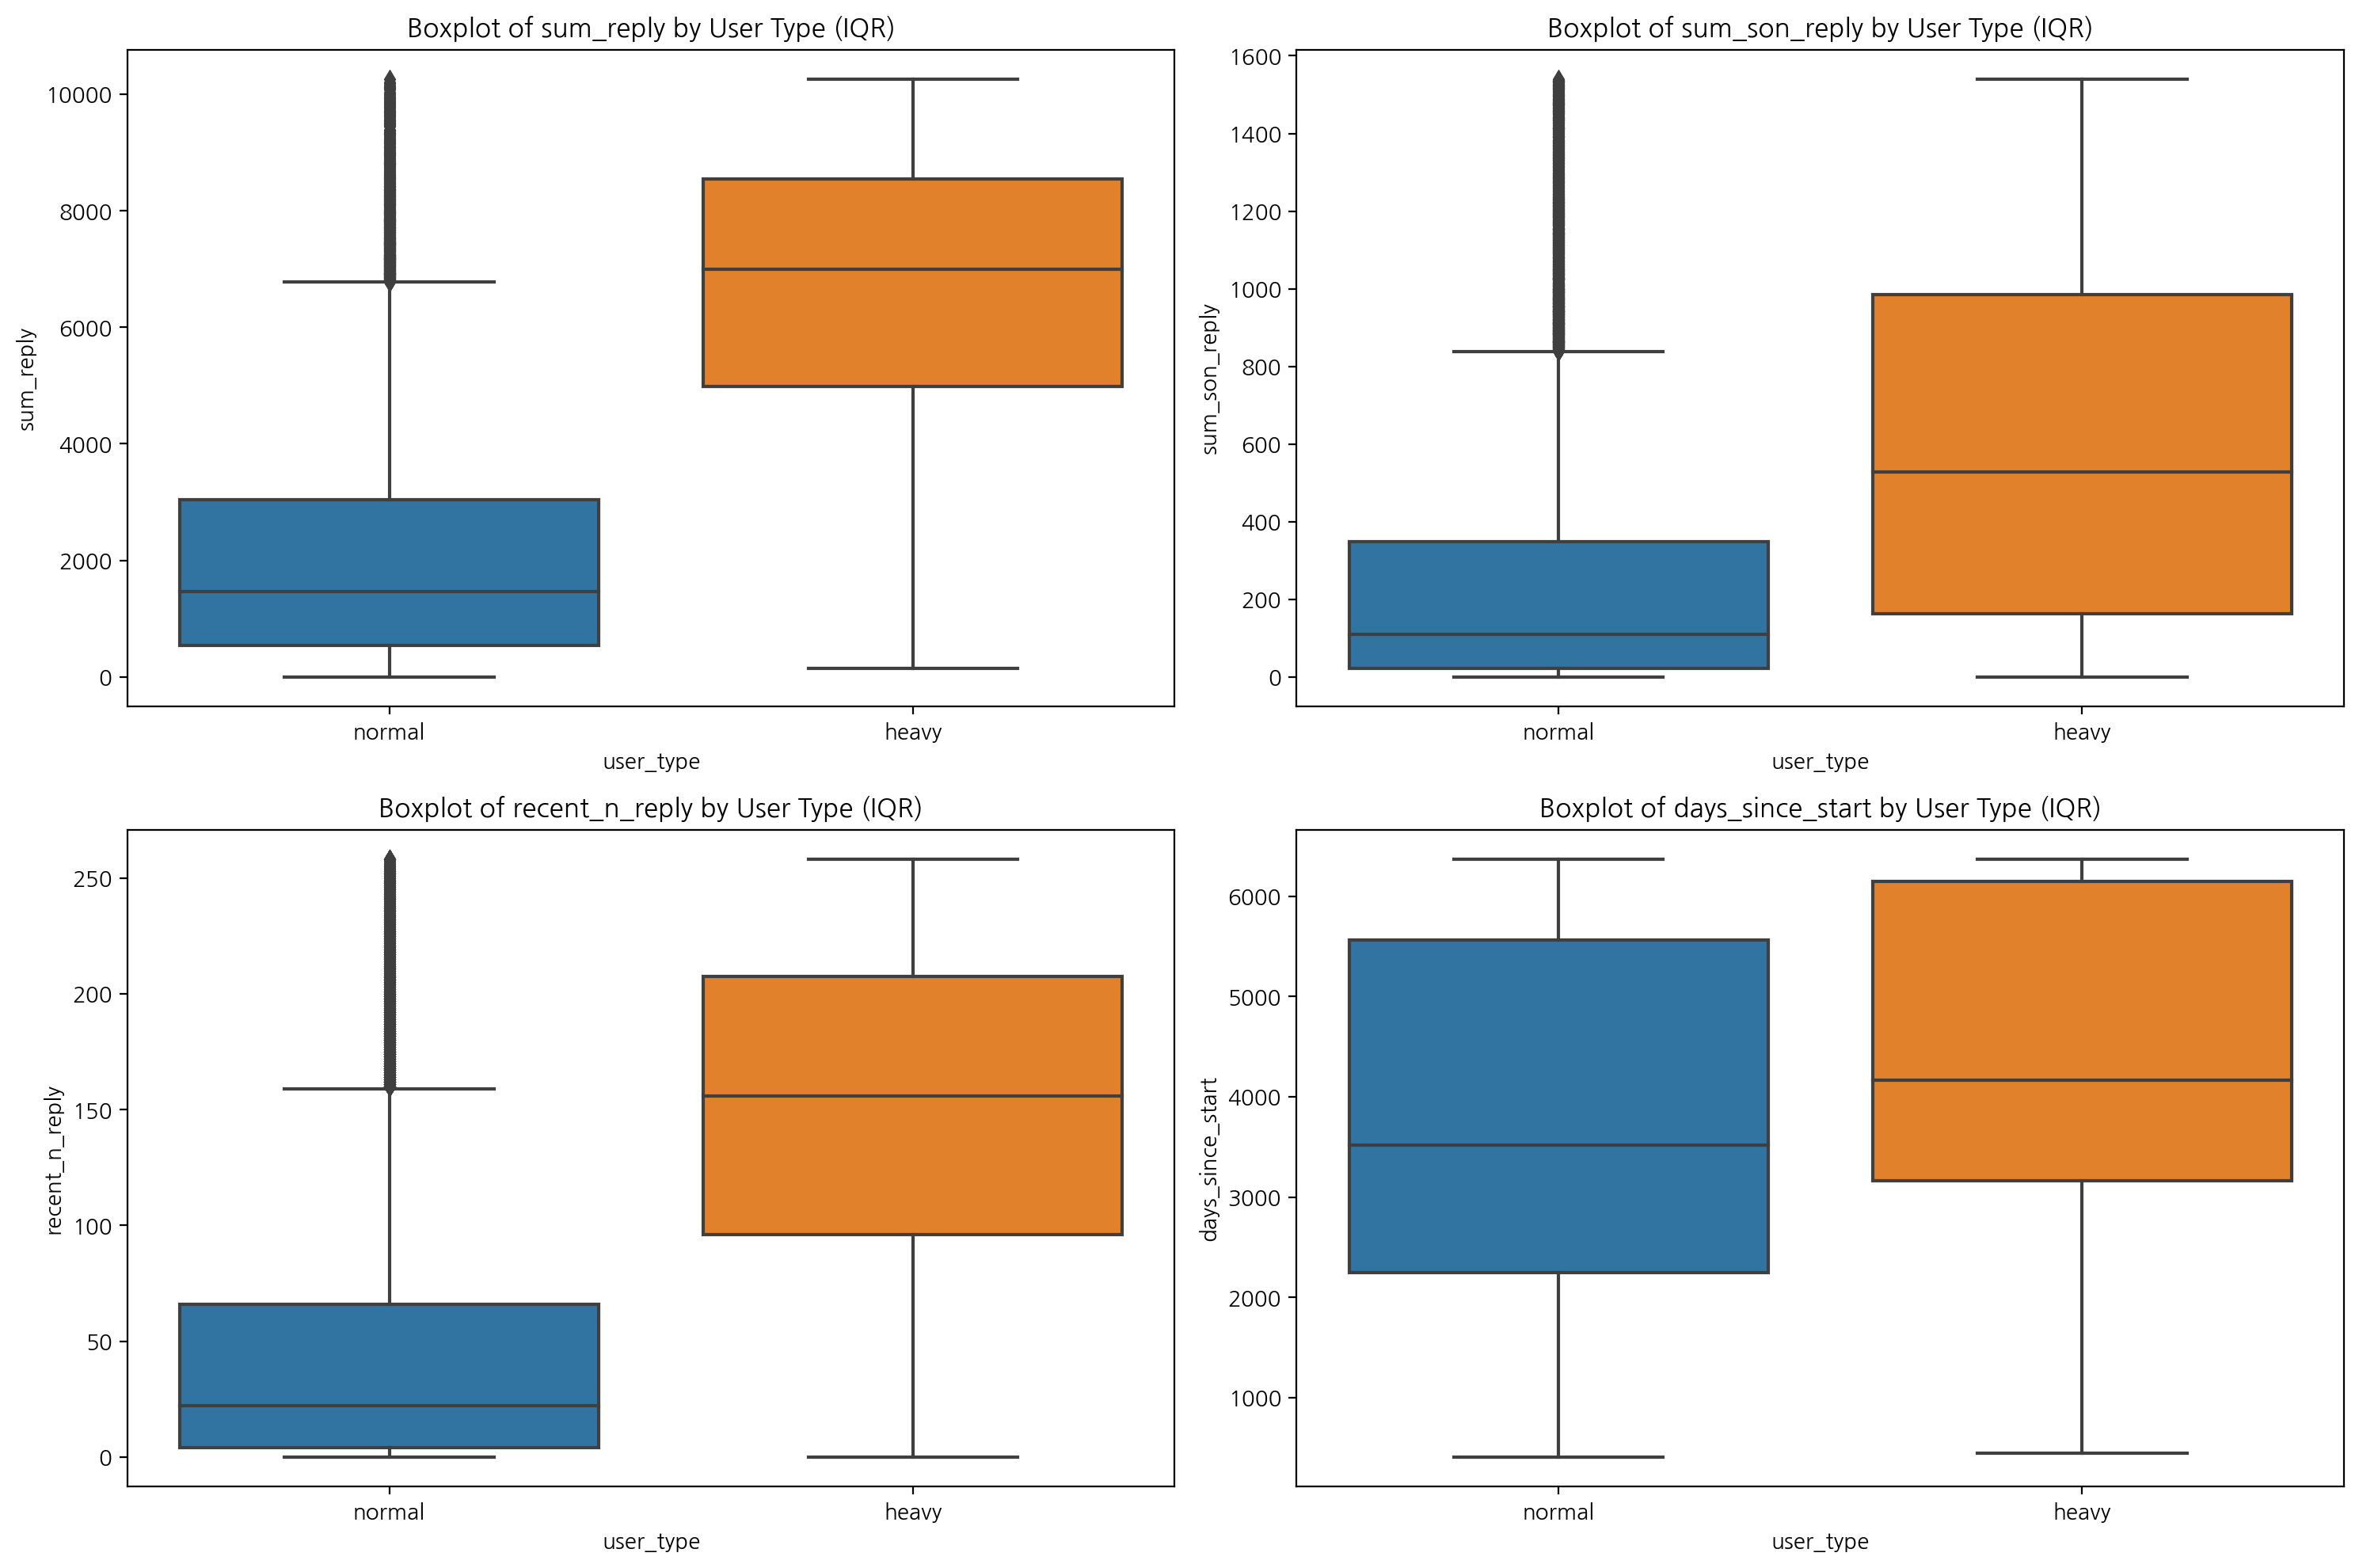

In [10]:
# Visualizations
plt.figure(figsize=(15, 10))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)
    # Q1, Q3, 그리고 IQR 계산
    Q1 = user_profile_df[feature].quantile(0.25)
    Q3 = user_profile_df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # IQR을 사용하여 이상치 찾기 및 제거
    user_profile_df_ = user_profile_df[(user_profile_df[feature] >= Q1 - 1.5 * IQR) & (user_profile_df[feature] <= Q3 + 1.5 * IQR)]
    sns.boxplot(x='user_type', y=feature, data=user_profile_df_)
    plt.title(f'Boxplot of {feature} by User Type (IQR)')

plt.tight_layout()
plt.show()

### 기사 댓글

In [43]:
reply_df_kome = pd.read_pickle('./reply_df_kome.pkl')
reply_df_kome

,idx,reply_user_id,reply,Neutral,Non-Moral-Emotion,Other-Condemming,Other-Praising,Other-Suffering,Self-Conscious
0,0,NXIM,문죄인 지가 가동중단 건설중단 시켜서 수천억 혈세 날려놓고 이제와서 뭐가어째? 윤석...,0.095336,0.149919,0.997376,0.006453,0.004827,0.036101
1,0,2Mh8r,"5년임기 내내 ""탈원전"" 을 부르짖었던 사람이..임기 한달 남겨두고 180도 달라지...",0.055879,0.117007,0.998107,0.004667,0.007348,0.129774
2,0,81WDL,문재앙은 원전 태양광 게이트만 제대로 수사받아도 평생 들어가 있을듯,0.200772,0.222707,0.993367,0.008692,0.004229,0.011016
3,0,vHmK,우리는 역사에서 지난 5년을 잃어 버렸다.,0.454929,0.903803,0.621771,0.031186,0.391626,0.315763
4,0,2lvoK,소머리가 태양광으로 마니 챙겼나,0.291822,0.173250,0.979102,0.023810,0.006801,0.017000
...,...,...,...,...,...,...,...,...,...
53710,503,2gIwW,지금추세는 인구증가중이거든요. 가만있으면 중간은가요,0.323550,0.406828,0.986525,0.005753,0.012320,0.051528
53711,503,1YXsi,구체적으로 말하는데 못 알아 들으니 어쩌냐,0.204384,0.123746,0.995068,0.003127,0.031297,0.429611
53712,505,28bkT,문죄인이는 죗값을 치뤄야 할것임.,0.382632,0.121113,0.988963,0.009493,0.004672,0.012120
53713,505,3vPoR,한전 피빨아먹는 좌파정권은 이제그만,0.063998,0.443054,0.996545,0.007162,0.006512,0.026610


In [44]:
reply_df_kome.loc[reply_df_kome['reply_user_id'].isin(hvy_users),'user_type'] = 'heavy'
reply_df_kome.loc[reply_df_kome['reply_user_id'].isin(nor_users),'user_type'] = 'normal'
reply_df_kome['user_type'].value_counts(normalize=True)

/tmp/ipykernel_3296312/3889090226.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'heavy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  reply_df_kome.loc[reply_df_kome['reply_user_id'].isin(hvy_users),'user_type'] = 'heavy'


user_type
normal    0.825523
heavy     0.174477
Name: proportion, dtype: float64

In [45]:
print(reply_df_kome[pd.isna(reply_df_kome['user_type'])]['reply_user_id'].nunique())
reply_df_kome[~pd.isna(reply_df_kome['user_type'])]['reply_user_id'].nunique()

2234


35608

In [46]:
reply_df_kome['idx'].nunique()

255

In [47]:
# merge
reply_df_kome = reply_df_kome.merge(target[['idx','title_p/n','e_policy_p/n']])

In [32]:
reply_df_kome.to_csv('./reply_df_kome_clu_v2.csv',index=None)

### 기사 분류 모델 결과 정리

In [11]:
# kpf_cls_list = natsorted(glob.glob('./kpfcls/*.pkl'))
# kpf_cls = pd.DataFrame()
# for cls in tqdm(kpf_cls_list):
#     res = pd.read_pickle(cls)
#     kpf_cls = pd.concat([kpf_cls, res],ignore_index=True)
# drop_duplicates
# kpf_cls = kpf_cls.drop_duplicates().reset_index(drop=True)
# date type으로 변환
# kpf_cls['date'] = pd.to_datetime(kpf_cls['date'])

In [29]:
kpf_cls = pd.read_parquet('./kpfcls/user_dic_history_kpf_unique.parquet')
kpf_cls

,user_id,정치,경제,사회,문화,국제,스포츠,IT_과학
0,NXIM,0.116415,0.004362,0.898731,0.999912,0.359332,0.296079,0.013149
1,NXIM,0.538330,1.000000,0.715426,0.000545,0.041586,0.000253,0.098358
2,NXIM,0.002404,0.001493,0.047836,0.001504,1.000000,0.000331,0.134920
3,NXIM,0.002510,0.002829,0.061708,0.000512,0.002621,0.123425,1.000000
4,NXIM,0.102152,0.000616,0.985847,0.996401,0.979018,0.289235,0.011100
...,...,...,...,...,...,...,...,...
55069673,EbqI,0.033150,0.002138,0.819189,0.999999,0.066429,0.151558,0.011994
55069674,EbqI,0.618901,1.000000,0.676774,0.000290,0.027867,0.000094,0.081022
55069675,EbqI,0.028550,0.002282,0.494308,0.007012,1.000000,0.017882,0.067211
55069676,EbqI,0.335130,0.000311,0.999985,0.001785,0.999967,0.021803,0.049065


In [30]:
kpf_cls['user_id'].value_counts()

user_id
gBmJ     4861
1ZjCM    4621
HqAS     4612
3jSHV    4569
2Bk2q    4524
         ... 
ehBmL       1
6w8pf       1
36tT0       1
2dM5J       1
4HsnZ       1
Name: count, Length: 37384, dtype: int64

count    37384.000000
mean      1473.081479
std       1204.436697
min          1.000000
25%        414.000000
50%       1142.000000
75%       2455.250000
max       4861.000000
Name: count, dtype: float64


<Axes: >

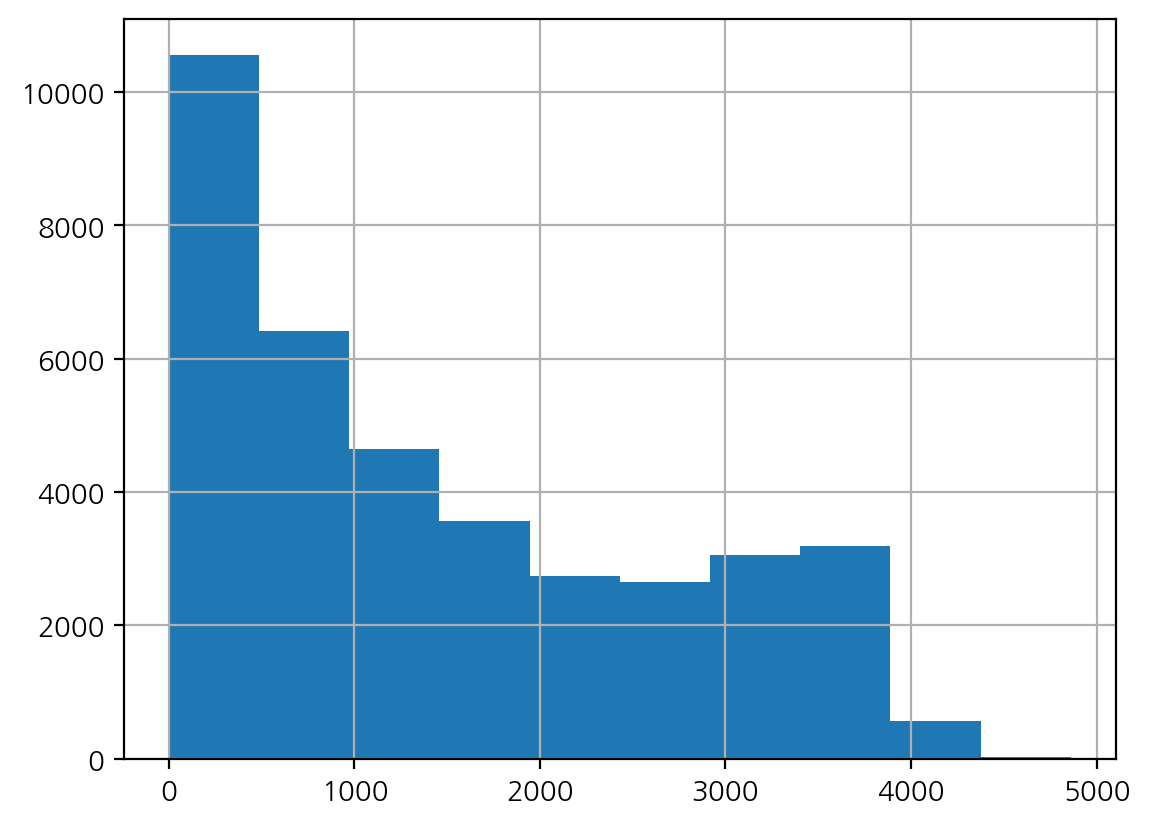

In [18]:
print(kpf_cls['user_id'].value_counts().describe())
kpf_cls['user_id'].value_counts().hist()

In [34]:
# big_label = ['정치', '경제', '사회', '문화', '국제', '스포츠', 'IT_과학']
kpf_cls.columns = ['user_id','Politics', 'Economy', 'Society', 'Culture', 'International', 'Sports', 'IT & Science']
big_label = ['Politics', 'Economy', 'Society', 'Culture', 'International', 'Sports', 'IT & Science']
kpf_cls[big_label].describe()

,Politics,Economy,Society,Culture,International,Sports,IT & Science
count,5.506968e+07,5.506968e+07,5.506968e+07,5.506968e+07,5.506968e+07,5.506968e+07,5.506968e+07
mean,5.331495e-01,1.627753e-01,4.697572e-01,1.296869e-01,6.496117e-01,6.431000e-02,9.068803e-02
std,4.238863e-01,3.549111e-01,4.131005e-01,3.200493e-01,3.745775e-01,1.319640e-01,1.896135e-01
min,1.367634e-04,4.766301e-05,6.103778e-03,4.970387e-05,4.928020e-04,3.577666e-06,2.782233e-05
25%,2.675956e-02,1.305093e-03,4.807719e-02,1.516429e-03,3.880155e-01,1.317751e-03,2.563202e-03
50%,6.665497e-01,2.492909e-03,3.910093e-01,2.633342e-03,7.958313e-01,5.305842e-03,4.703682e-02
75%,9.999999e-01,1.493065e-02,9.378410e-01,1.963447e-02,9.999634e-01,5.398273e-02,9.026533e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,9.999998e-01,1.000000e+00,1.000000e+00,1.000000e+00


/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

[Text(0, 0, 'Politics'),
 Text(1, 0, 'Economy'),
 Text(2, 0, 'Society'),
 Text(3, 0, 'Culture'),
 Text(4, 0, 'International'),
 Text(5, 0, 'Sports'),
 Text(6, 0, 'IT & Science')]

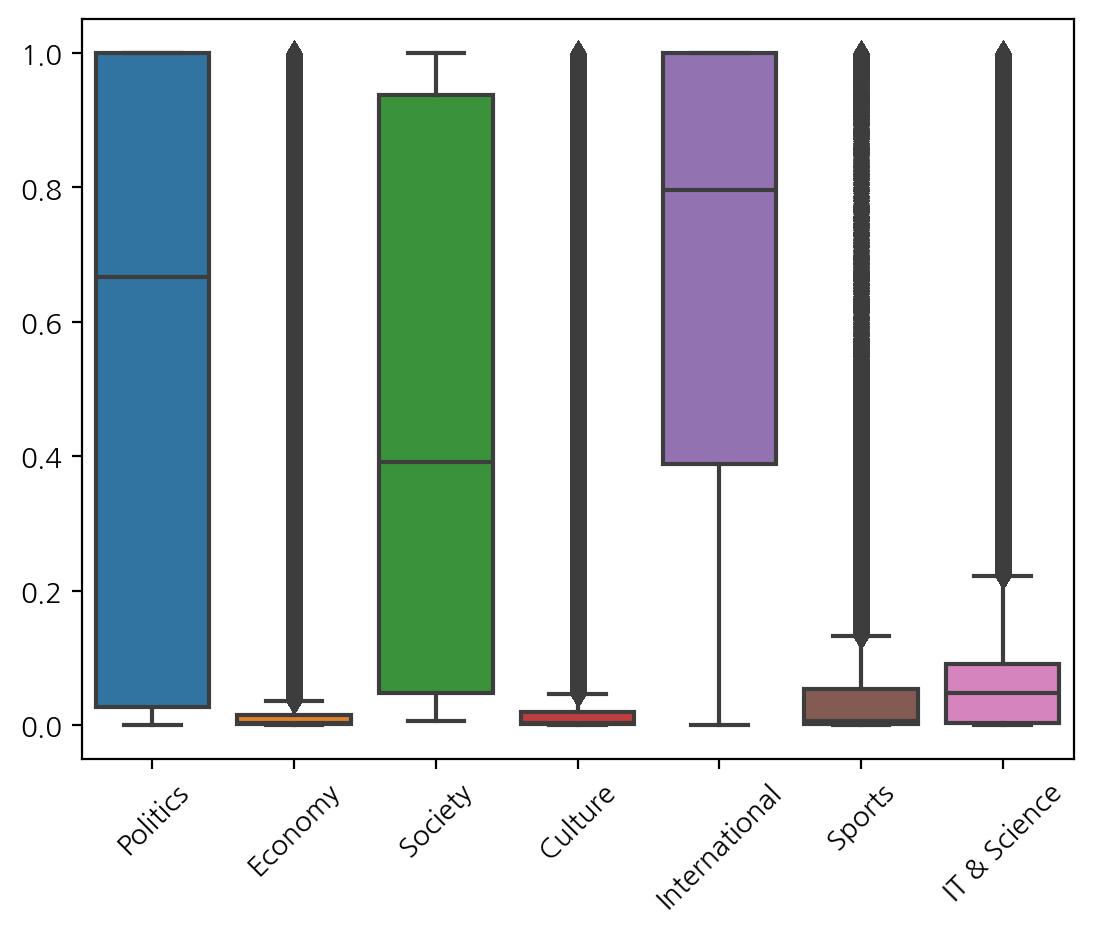

In [35]:
g = sns.boxplot(data = kpf_cls[big_label])
g.set_xticklabels(g.get_xticklabels(), rotation=45)

In [39]:
kpf_cls.loc[kpf_cls['user_id'].isin(hvy_users),'user_type'] = 'heavy'
kpf_cls.loc[kpf_cls['user_id'].isin(nor_users),'user_type'] = 'normal'

/tmp/ipykernel_3296312/650934784.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'heavy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  kpf_cls.loc[kpf_cls['user_id'].isin(hvy_users),'user_type'] = 'heavy'


In [23]:
kpf_cls['user_type'].value_counts(normalize=True)

user_type
normal    0.74541
heavy     0.25459
Name: proportion, dtype: float64

In [27]:
kpf_cls

,user_id,정치,경제,사회,문화,국제,스포츠,IT_과학,user_type
0,NXIM,0.116415,0.004362,0.898731,0.999912,0.359332,0.296079,0.013149,normal
1,NXIM,0.538330,1.000000,0.715426,0.000545,0.041586,0.000253,0.098358,normal
2,NXIM,0.002404,0.001493,0.047836,0.001504,1.000000,0.000331,0.134920,normal
3,NXIM,0.002510,0.002829,0.061708,0.000512,0.002621,0.123425,1.000000,normal
4,NXIM,0.102152,0.000616,0.985847,0.996401,0.979018,0.289235,0.011100,normal
...,...,...,...,...,...,...,...,...,...
55069673,EbqI,0.033150,0.002138,0.819189,0.999999,0.066429,0.151558,0.011994,normal
55069674,EbqI,0.618901,1.000000,0.676774,0.000290,0.027867,0.000094,0.081022,normal
55069675,EbqI,0.028550,0.002282,0.494308,0.007012,1.000000,0.017882,0.067211,normal
55069676,EbqI,0.335130,0.000311,0.999985,0.001785,0.999967,0.021803,0.049065,normal


/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

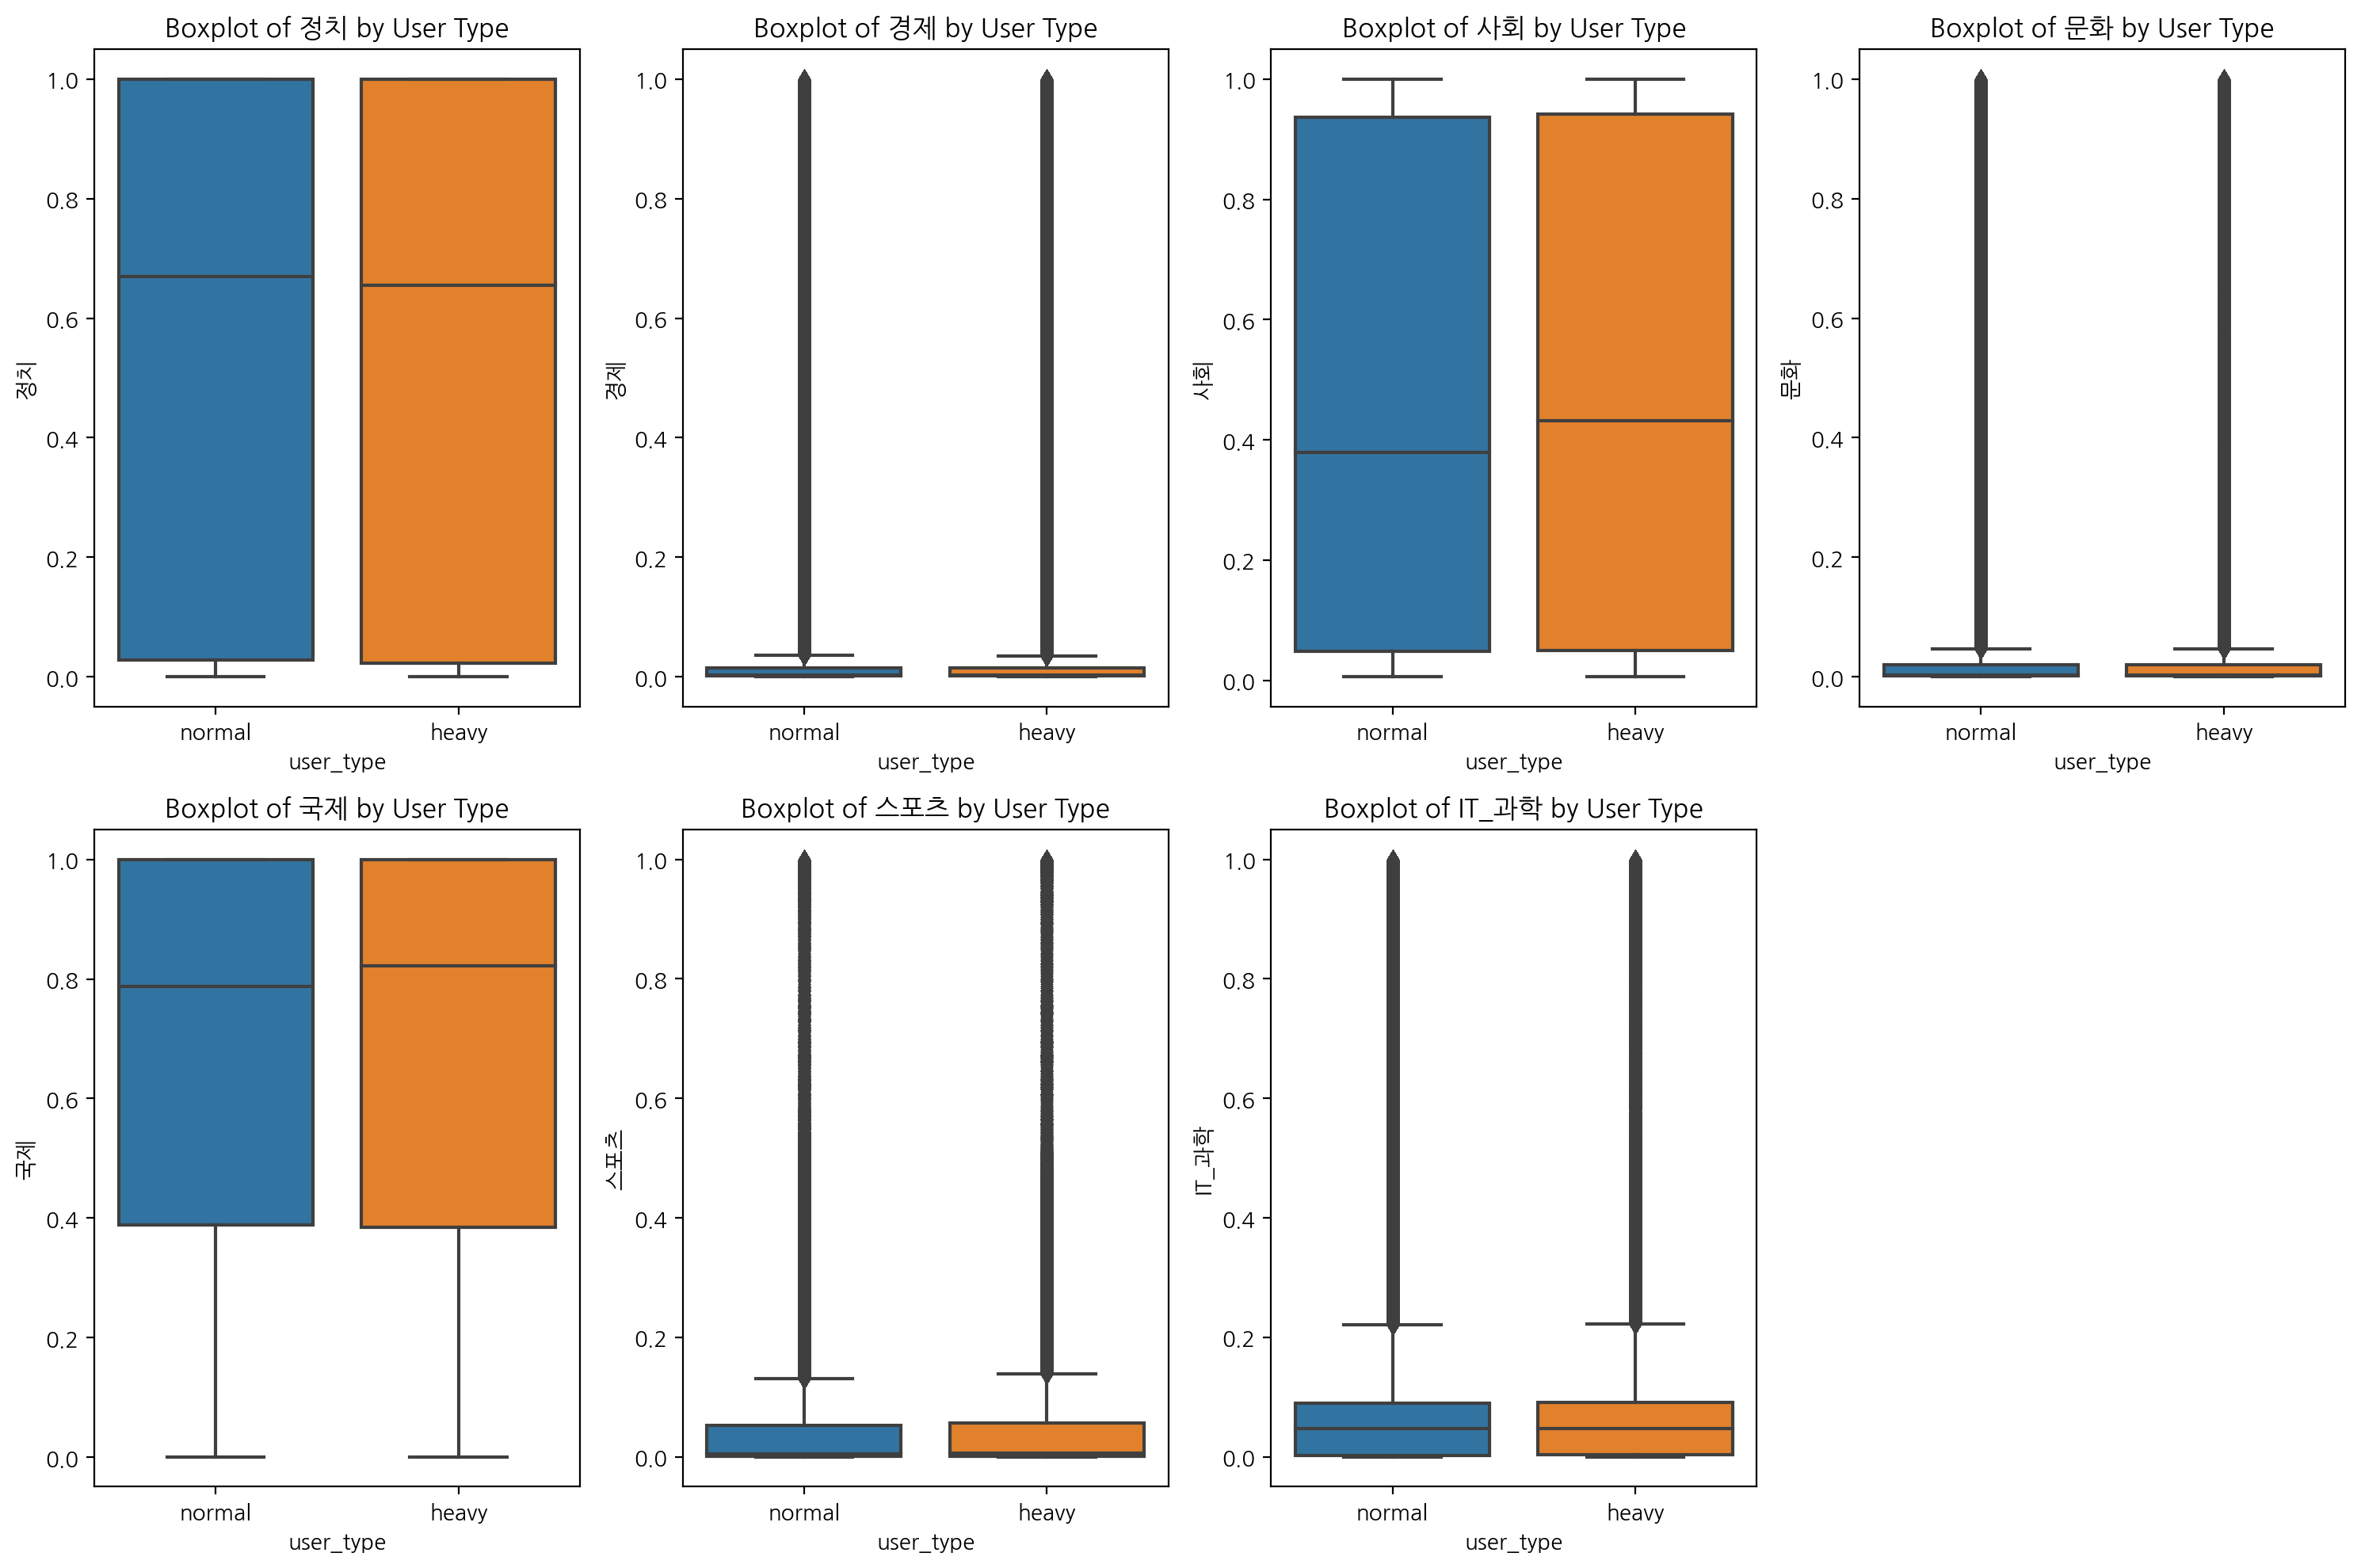

In [30]:
# Visualizations
plt.figure(figsize=(15, 10))

for i, feature in enumerate(big_label, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='user_type', y=feature, data=kpf_cls)
    plt.title(f'Boxplot of {feature} by User Type')

plt.tight_layout()
plt.show()

In [42]:
mannwhitneyu(kpf_cls.loc[kpf_cls['user_type']=='heavy','Politics'].tolist(),kpf_cls.loc[kpf_cls['user_type']=='normal','Politics'].tolist())

MannwhitneyuResult(statistic=282648188057470.5, pvalue=0.0)

In [35]:
mannwhitneyu(kpf_cls.loc[kpf_cls['user_type']=='heavy','사회'].tolist(),kpf_cls.loc[kpf_cls['user_type']=='normal','사회'].tolist())

MannwhitneyuResult(statistic=290736410860364.0, pvalue=0.0)

In [36]:
mannwhitneyu(kpf_cls.loc[kpf_cls['user_type']=='heavy','국제'].tolist(),kpf_cls.loc[kpf_cls['user_type']=='normal','국제'].tolist())

MannwhitneyuResult(statistic=289646626189966.5, pvalue=7.884496546715833e-295)

In [41]:
kpf_cls.groupby('user_id')[LABELS].median().reset_index()

,user_id,정치,경제,사회,문화,국제,스포츠,IT_과학,user_type
0,NXIM,0.116415,0.004362,0.898731,0.999912,0.359332,0.296079,0.013149,normal
1,NXIM,0.538330,1.000000,0.715426,0.000545,0.041586,0.000253,0.098358,normal
2,NXIM,0.002404,0.001493,0.047836,0.001504,1.000000,0.000331,0.134920,normal
3,NXIM,0.002510,0.002829,0.061708,0.000512,0.002621,0.123425,1.000000,normal
4,NXIM,0.102152,0.000616,0.985847,0.996401,0.979018,0.289235,0.011100,normal
...,...,...,...,...,...,...,...,...,...
55069673,EbqI,0.033150,0.002138,0.819189,0.999999,0.066429,0.151558,0.011994,normal
55069674,EbqI,0.618901,1.000000,0.676774,0.000290,0.027867,0.000094,0.081022,normal
55069675,EbqI,0.028550,0.002282,0.494308,0.007012,1.000000,0.017882,0.067211,normal
55069676,EbqI,0.335130,0.000311,0.999985,0.001785,0.999967,0.021803,0.049065,normal


In [43]:
kpf_cls_median = kpf_cls.groupby('user_id')[big_label].median().reset_index()

### 유저 감정 히스토리

In [6]:
history_df = pd.read_parquet('./KOME/history_df_kome.parquet')

In [9]:
history_df.columns = ['text', 'date', 'good', 'bad', 'url', 'title', 'press', 'n_reply',
       'user_id', 'Neutral', 'Non-Moral-Emotion', 'Condemning',
       'Praising', 'Suffering', 'Conscious']

In [10]:
# LABELS = ['Neutral', 'Non-Moral-Emotion', 'Other-Condemning', 'Other-Praising', 'Other-Suffering', 'Self-Conscious']
LABELS = ['Condemning','Praising', 'Suffering', 'Conscious']

In [11]:
# 유저별 감정 중앙값 도출
history_df_median = history_df.groupby('user_id')[LABELS].median().reset_index()
history_df_median

,user_id,Condemning,Praising,Suffering,Conscious
0,100n7,0.995614,0.009502,0.006512,0.040071
1,100yT,0.995838,0.009454,0.007527,0.042978
2,102YE,0.994559,0.008334,0.010739,0.036897
3,102uj,0.995719,0.006992,0.007677,0.068020
4,1036s,0.996734,0.005735,0.007753,0.042561
...,...,...,...,...,...
37379,zwbF,0.992847,0.007545,0.011537,0.049924
37380,zyWZ,0.994705,0.007019,0.009824,0.041867
37381,zye1,0.996095,0.008019,0.008760,0.035890
37382,zyyp,0.993333,0.017991,0.006317,0.047783


/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

[Text(0, 0, 'Condemning'),
 Text(1, 0, 'Praising'),
 Text(2, 0, 'Suffering'),
 Text(3, 0, 'Conscious')]

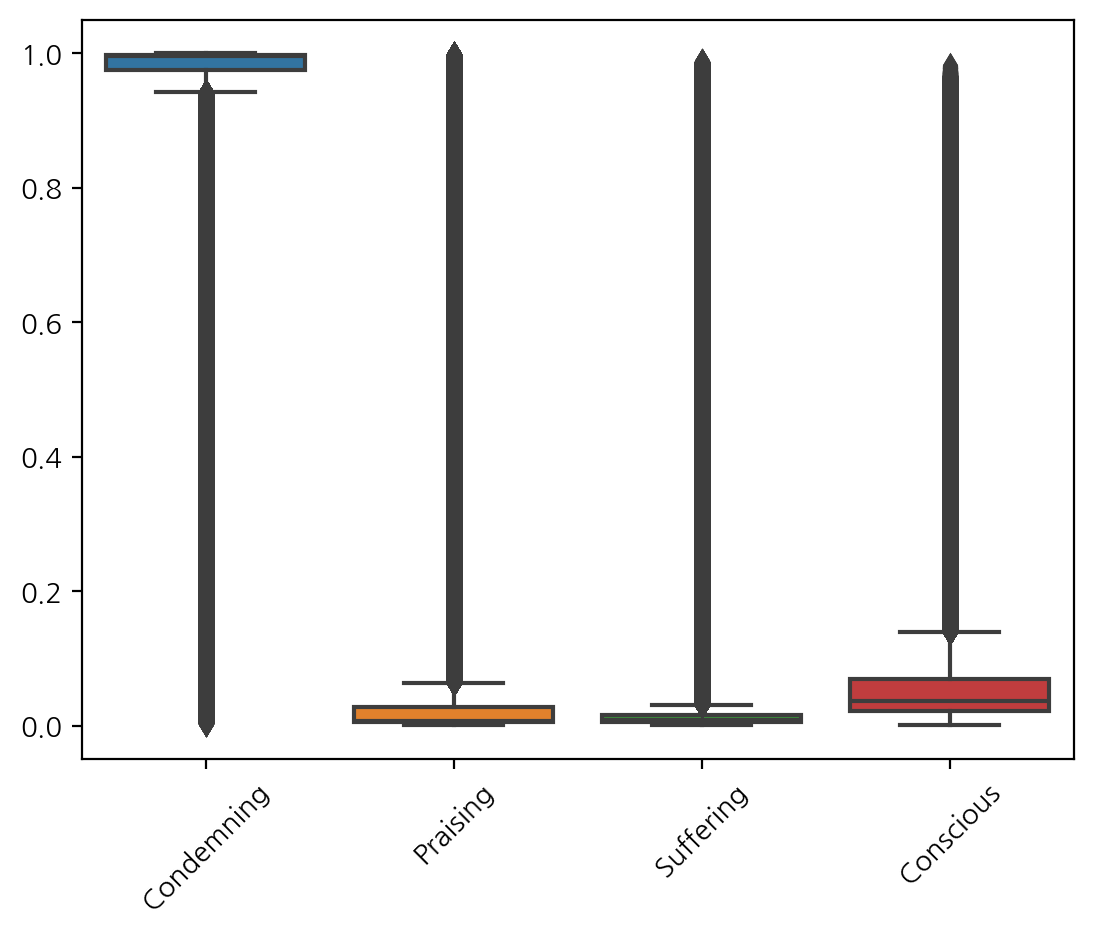

In [13]:
g = sns.boxplot(data = history_df[LABELS])
g.set_xticklabels(g.get_xticklabels(), rotation=45)

In [14]:
history_df[LABELS].describe()

,Condemning,Praising,Suffering,Conscious
count,5.519466e+07,5.519466e+07,5.519466e+07,5.519466e+07
mean,9.068266e-01,9.454914e-02,2.662501e-02,6.849466e-02
std,2.282685e-01,2.285417e-01,8.510334e-02,9.877777e-02
min,2.938922e-03,7.746791e-04,5.139061e-04,7.577828e-04
25%,9.752441e-01,5.092350e-03,5.533152e-03,2.236532e-02
50%,9.953028e-01,7.790186e-03,8.537753e-03,3.698610e-02
75%,9.970784e-01,2.845017e-02,1.575763e-02,6.941476e-02
max,9.992931e-01,9.983793e-01,9.888419e-01,9.821298e-01


/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

[Text(0, 0, 'Condemning'),
 Text(1, 0, 'Praising'),
 Text(2, 0, 'Suffering'),
 Text(3, 0, 'Conscious')]

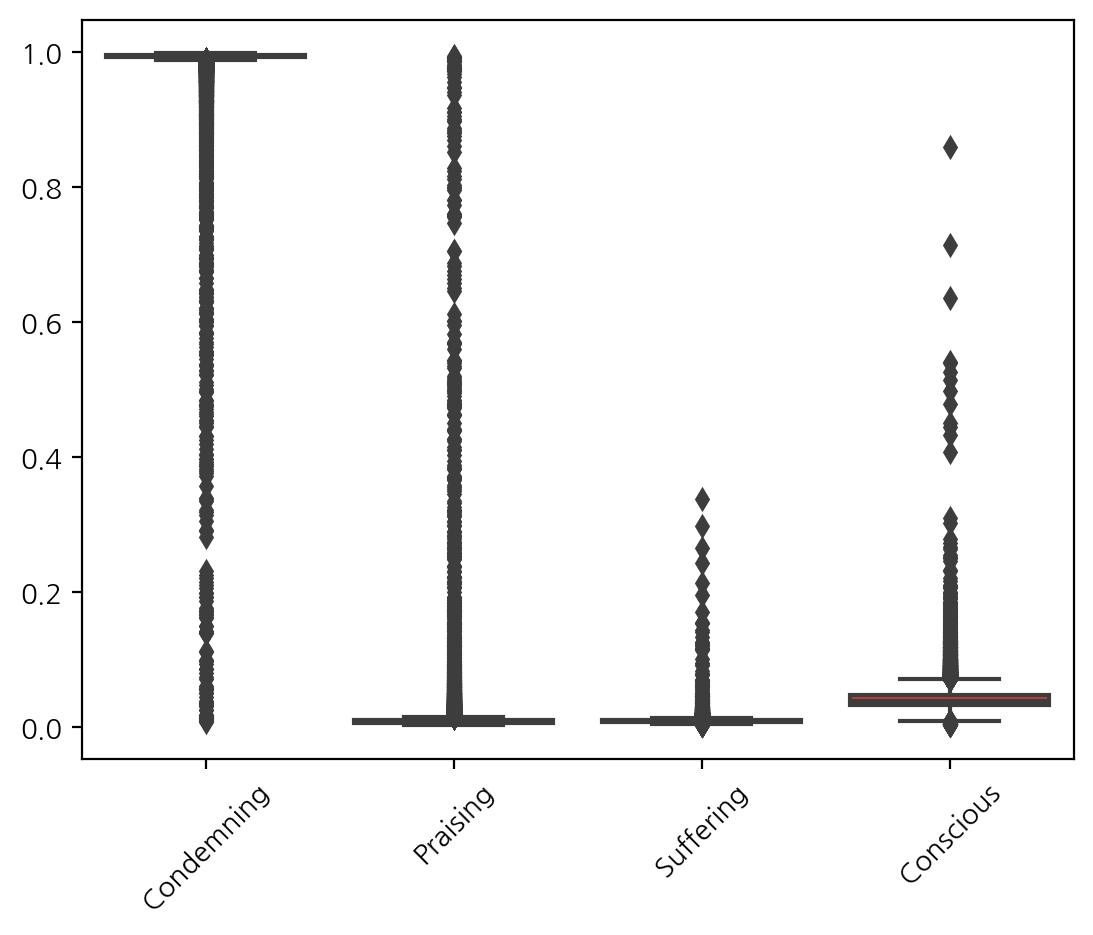

In [12]:
g = sns.boxplot(data = history_df_median[LABELS])
g.set_xticklabels(g.get_xticklabels(), rotation=45)

In [15]:
history_df_median[LABELS].describe()

,Condemning,Praising,Suffering,Conscious
count,37384.000000,37384.000000,37384.000000,37384.000000
mean,0.988551,0.013477,0.009381,0.042437
std,0.050019,0.046442,0.005258,0.018393
min,0.007015,0.002689,0.002378,0.002437
25%,0.992997,0.006724,0.007637,0.032619
50%,0.995200,0.007818,0.008698,0.039394
75%,0.996174,0.010137,0.010129,0.048163
max,0.998285,0.994165,0.338503,0.860311


### 과거 감정/댓글 기사 분류 통합

In [69]:
reply_df_kome_merge = reply_df_kome.merge(kpf_cls_median,left_on='reply_user_id',right_on='user_id',how='left')

In [62]:
history_df_median.columns = ['user_id'] + [l + '_past' for l in LABELS]

In [64]:
history_df_median

,user_id,Neutral_past,Non-Moral-Emotion_past,Other-Condemning_past,Other-Praising_past,Other-Suffering_past,Self-Conscious_past
0,100n7,0.158175,0.187261,0.995614,0.009502,0.006512,0.040071
1,100yT,0.114900,0.246605,0.995838,0.009454,0.007527,0.042978
2,102YE,0.079513,0.283621,0.994559,0.008334,0.010739,0.036897
3,102uj,0.069881,0.286904,0.995719,0.006992,0.007677,0.068020
4,1036s,0.067918,0.229192,0.996734,0.005735,0.007753,0.042561
...,...,...,...,...,...,...,...
37379,zwbF,0.099133,0.298790,0.992847,0.007545,0.011537,0.049924
37380,zyWZ,0.104985,0.268128,0.994705,0.007019,0.009824,0.041867
37381,zye1,0.089377,0.231636,0.996095,0.008019,0.008760,0.035890
37382,zyyp,0.134125,0.159355,0.993333,0.017991,0.006317,0.047783


In [70]:
reply_df_kome_merge = reply_df_kome_merge.merge(history_df_median,left_on='reply_user_id',right_on='user_id',how='left')

In [76]:
reply_df_kome_merge = reply_df_kome_merge[['idx', 'reply_user_id', 'reply', 'Neutral', 'Non-Moral-Emotion',\
       'Other-Condemming', 'Other-Praising', 'Other-Suffering',\
       'Self-Conscious', 'user_type', 'title_p/n', 'e_policy_p/n',\
       '정치', '경제', '사회', '문화', '국제', '스포츠', 'IT_과학',\
       'Neutral_past', 'Non-Moral-Emotion_past', 'Other-Condemning_past',\
       'Other-Praising_past', 'Other-Suffering_past', 'Self-Conscious_past']]

In [101]:
def tokenize(sent):
    res = kiwi.tokenize(sent, normalize_coda=True)
    return [word+'/'+tag for word, tag, _, _ in res
            if not tag.startswith('W')] # 웹관련(w) 형태소 제거

In [103]:
tokenize("ㅋㅋㅋ 이런 것도 분석이 될까욬ㅋㅋㅋㅋ?")

['ㅋㅋㅋ/SW',
 '이런/MM',
 '것/NNB',
 '도/JX',
 '분석/NNG',
 '이/JKC',
 '되/VV',
 'ᆯ까요/EF',
 'ㅋㅋㅋㅋㅋ/SW',
 '?/SF']

In [106]:
reply_df_kome_merge['tokens'] = reply_df_kome_merge['reply'].progress_map(lambda x:tokenize(x))

100%|██████████| 53715/53715 [01:32<00:00, 581.19it/s]


In [114]:
def calculate_ttr(tokens):
    # Tokenize the text into words
    # tokens = text.split()
    
    # Count the total number of tokens
    total_tokens = len(tokens)

    if total_tokens!=0:
        # Count the number of unique tokens (types)
        unique_tokens = len(set(tokens))
        
        # Calculate the Term-to-Term Ratio (TTR)
        ttr = unique_tokens / total_tokens
    else:
        ttr = 0
        
    return ttr

In [124]:
reply_df_kome_merge['tokens_len'] = reply_df_kome_merge['tokens'].str.len()

In [127]:
reply_df_kome_merge = reply_df_kome_merge[reply_df_kome_merge['tokens_len']!=0].reset_index(drop=True)

In [128]:
reply_df_kome_merge['ttr'] = reply_df_kome_merge['tokens'].progress_map(lambda x:calculate_ttr(x))

100%|██████████| 53707/53707 [00:00<00:00, 533946.50it/s]


In [132]:
reply_df_kome_merge.to_csv('./reply_df_kome_merge.csv',index=None)

### 과거 유저 Token수, TTR 중앙값 확인

In [13]:
reply_df_kome_merge = pd.read_pickle('./reply_df_kome_merge.pkl')
reply_df_kome_merge.columns

Index(['idx', 'reply_user_id', 'reply', 'Neutral', 'Non-Moral-Emotion',
       'Other-Condemning', 'Other-Praising', 'Other-Suffering',
       'Self-Conscious', 'user_type', 'title_p/n', 'e_policy_p/n', '정치', '경제',
       '사회', '문화', '국제', '스포츠', 'IT_과학', 'Neutral_past',
       'Non-Moral-Emotion_past', 'Other-Condemning_past',
       'Other-Praising_past', 'Other-Suffering_past', 'Self-Conscious_past',
       'tokens', 'tokens_len', 'ttr'],
      dtype='object')

In [14]:
reply_df_kome_merge[['tokens_len','ttr']].describe()

,tokens_len,ttr
count,53707.000000,53707.000000
mean,32.105424,0.906393
std,30.995368,0.101075
min,1.000000,0.026667
25%,12.000000,0.844444
50%,22.000000,0.931034
75%,41.000000,1.000000
max,218.000000,1.000000


In [7]:
history_df = pd.read_parquet('./user_dic_history/user_dic_history_all_token.parquet')
history_df

,text,date,good,bad,url,title,press,n_reply,user_id,tokens,tokens_len,ttr
0,박의장도 문죄인정부가 분열정치 갈라치기 정치가 심했다는걸 인정했네,2022-05-30 00:18:29,0,0,https://n.news.naver.com/mnews/article/001/001...,여야 기립박수 받고 떠난 박 의장…\,연합뉴스,73,NXIM,"[박/NNP, 의장/NNG, 도/JX, 문/NNG, 죄인/NNG, 정부/NNG, 가...",24,0.875000
1,부정투표로 180석 해먹고 또 그짓거리해서 대선까지 해먹으려고?? 5년동안 대한민국...,2022-03-08 03:02:32,4,0,https://news.naver.com/main/read.naver?mode=LS...,"공무원노조 “부실 사전투표 선관위, 철저한 진상규명해야”",이데일리,227,NXIM,"[부정/NNG, 투표/NNG, 로/JKB, 180/SN, 석/NNB, 하/VV, 어...",61,0.803279
2,저번총선때 다량의 투표용지가 버려진채 발견된게 조작이 아니였네 당시 민명욱의원 한명...,2022-03-06 18:51:25,0,0,https://news.naver.com/main/read.naver?mode=LS...,"이번엔 부실 선거관리 도마…사면초가 선관위, 커지는 책임론",연합뉴스,94,NXIM,"[저/MM, 번/NNB, 총선/NNG, 때/NNG, 다량/NNG, 의/JKG, 투표...",102,0.735294
3,국토부장관놈 부하직원 아닌가?? 그말인 즉슨 민주당 너희 식구고 어디서 꼬리자르기냐 ㅉㅉ,2021-03-04 11:47:32,2,0,https://news.naver.com/main/read.nhn?mode=LSD∣...,"김태년 “LH 투기 의혹, 반사회적 범죄…패가망신 귀결될 것”",서울신문,46,NXIM,"[국토부/NNG, 장관/NNG, 놈/NNG, 부하/NNG, 직원/NNG, 아니/VC...",28,0.892857
4,대통령 임기4년동안 한번도 언급조차 안했던 가덕도를 참 기가찬다 문재인 ㅉㅉ,2021-02-25 17:17:22,5,1,https://news.naver.com/main/read.nhn?mode=LSD∣...,"野, 문대통령 부산행에 격앙…\",연합뉴스,829,NXIM,"[대통령/NNG, 임기/NNG, 4/SN, 년/NNB, 동안/NNG, 한/MM, 번...",23,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
55194658,헬스장은.못해도 개인pt는 해줘도 되지 않냐 이 재앙이들아\n아니면 스키장처럼 몇명...,2021-01-04 08:07:34,4,0,https://news.naver.com/main/read.nhn?mode=LSD∣...,본인 헬스장서 관장 극단적 선택 \,데일리안,420,EbqI,"[헬스장/NNG, 은/JX, ./SF, 못/MAG, 하/VV, 어도/EC, 개인/N...",55,0.818182
55194659,기존 제대로 혜택 못받은 사람들도 같이.적용해야지 \n무슨 복권도 아니고,2020-12-06 19:51:29,1,2,https://news.naver.com/main/read.nhn?mode=LSD∣...,'車 개소세 인하 연장' 만지작,서울경제,42,EbqI,"[기존/NNG, 제대로/MAG, 혜택/NNG, 못/MAG, 받/VV-R, 은/ETM...",21,0.952381
55194660,이미 당신네들 파업으로 죽은사람들이 있습니다. 그 사람들 유족들한테 찾아가서 사과합...,2020-10-08 16:42:38,1,1,https://news.naver.com/main/read.nhn?mode=LSD∣...,"박능후, 병원장들 사과에도 \",연합뉴스,592,EbqI,"[이미/MAG, 당신/NP, 네/XSN, 들/XSN, 파업/NNG, 으로/JKB, ...",160,0.643750
55194661,트럼프야 하나님 만나거라,2020-10-06 21:52:09,0,0,https://news.naver.com/main/read.nhn?mode=LSD∣...,"트럼프, '음성 판정' 없이 퇴원 강행…\",JTBC,445,EbqI,"[트럼프/NNP, 야/JX, 하나님/NNG, 만나/VV, 거라/EC]",5,1.000000


In [22]:
history_df_token_ttr_median = pd.DataFrame(history_df.groupby(['user_id'])['tokens_len'].median()).reset_index()
history_df_token_ttr_median = history_df_token_ttr_median.merge(pd.DataFrame(history_df.groupby(['user_id'])['ttr'].median()).reset_index())
history_df_token_ttr_median.columns = ['reply_user_id','tokens_len_past','ttr_past']

In [26]:
len(reply_df_kome_merge.dropna())

50986

In [27]:
# merge
reply_df_kome_merge_token = reply_df_kome_merge.merge(history_df_token_ttr_median, on='reply_user_id')
reply_df_kome_merge_token.to_parquet('./reply_df_kome_merge_token.parquet',compression='gzip')

In [26]:
reply_df_kome_merge_token = pd.read_parquet('./reply_df_kome_merge_token.parquet')
reply_df_kome_merge_token.columns

Index(['idx', 'reply_user_id', 'reply', 'Neutral', 'Non-Moral-Emotion',
       'Other-Condemning', 'Other-Praising', 'Other-Suffering',
       'Self-Conscious', 'user_type', 'title_p/n', 'e_policy_p/n', '정치', '경제',
       '사회', '문화', '국제', '스포츠', 'IT_과학', 'Neutral_past',
       'Non-Moral-Emotion_past', 'Other-Condemning_past',
       'Other-Praising_past', 'Other-Suffering_past', 'Self-Conscious_past',
       'tokens', 'tokens_len', 'ttr', 'tokens_len_past', 'ttr_past'],
      dtype='object')

##### 상위 단어 (명사)

In [34]:
reply_df_kome_merge_token['tokens'] = reply_df_kome_merge_token['tokens'].map(lambda x:list(x))

In [52]:
# 명사만 추출
nouns = reply_df_kome_merge_token['tokens'].tolist()
nouns = [[w for w in l if w.split('/')[1]=='NNG' or w.split('/')[1]=='NNP'] for l in nouns]

In [62]:
# 상위 n개 Unigram 확인
nouns_tokens = chain(*nouns)
cnt = Counter(nouns_tokens)
pd.DataFrame(cnt.most_common(20), columns=['Unigram','Frequency']).to_excel('./unigram_keywords.xlsx')

In [54]:
def make_bigram(data_words,bigram_min_count):
    bigram = gensim.models.Phrases(data_words, min_count=bigram_min_count)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    # bigram으로 만들기
    data_words_bigrams = [bigram_mod[doc] for doc in data_words] # 불용어 1차 제거 후에 bigram
    # data_lemmatized = remove_stopwords(lemmatization(data_words_bigrams,allowed_postags=['NOUN','PROPN','ADJ','ADV','VERB'])) #lemm 이후 불용어 추가 제거
    return data_words_bigrams

In [56]:
bigram = make_bigram(nouns,100)  # N회 이상 등장한 단어만 bigram 처리

In [66]:
# bigram 단어 확인
bigram_list = [word for sent in bigram for word in sent if "_" in word]
pd.DataFrame(Counter(bigram_list).most_common(20), columns=['Bigram','Frequency']).to_excel('./bigram_keywords.xlsx')
Counter(bigram_list).most_common(20) # 상위 N개

[('문/NNG_재앙/NNG', 1650),
 ('재생/NNG_에너지/NNG', 971),
 ('탄소/NNG_중립/NNG', 730),
 ('전기/NNG_요금/NNG', 728),
 ('정권/NNG_교체/NNG', 586),
 ('문/NNG_죄인/NNG', 580),
 ('태양광/NNG_패널/NNG', 548),
 ('태양광/NNG_풍력/NNG', 449),
 ('대/NNG_강/NNG', 409),
 ('세계/NNG_최고/NNG', 332),
 ('환경/NNG_단체/NNG', 324),
 ('문/NNP_정부/NNG', 278),
 ('태양광/NNG_설치/NNG', 256),
 ('원자력/NNG_발전소/NNG', 255),
 ('전기/NNG_차/NNG', 220),
 ('문/NNG_통/NNG', 216),
 ('전기료/NNG_인상/NNG', 200),
 ('전기/NNG_생산/NNG', 197),
 ('핵/NNG_폐기물/NNG', 186),
 ('폐기물/NNG_처리/NNG', 183)]

##### Statistical Test

In [19]:
df = reply_df_kome_merge_token[['idx','reply_user_id','Other-Condemning', 'Other-Praising', 'Other-Suffering',
       'Self-Conscious', 'user_type', 'title_p/n', 'e_policy_p/n','tokens_len', 'ttr']]

In [20]:
df.columns = ['idx','reply_user_id','Condemning', 'Praising', 'Suffering',
       'Self-Conscious', 'user_type', 'title_p/n', 'e_policy_p/n','tokens_len', 'ttr']

In [22]:
df.loc[df['title_p/n']==1,'title_p/n'] = 'Positive'
df.loc[df['title_p/n']==0,'title_p/n'] = 'Neutral'
df.loc[df['title_p/n']==-1,'title_p/n'] = 'Negative'

/tmp/ipykernel_4151306/2480626841.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Positive' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['title_p/n']==1,'title_p/n'] = 'Positive'


In [23]:
df.loc[df['e_policy_p/n']==1,'e_policy_p/n'] = 'Positive'
df.loc[df['e_policy_p/n']==0,'e_policy_p/n'] = 'Neutral'
df.loc[df['e_policy_p/n']==-1,'e_policy_p/n'] = 'Negative'

/tmp/ipykernel_4151306/1292215247.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Positive' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['e_policy_p/n']==1,'e_policy_p/n'] = 'Positive'


/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bjkim/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

[Text(0, 0, 'Condemning'),
 Text(1, 0, 'Praising'),
 Text(2, 0, 'Suffering'),
 Text(3, 0, 'Self-Conscious')]

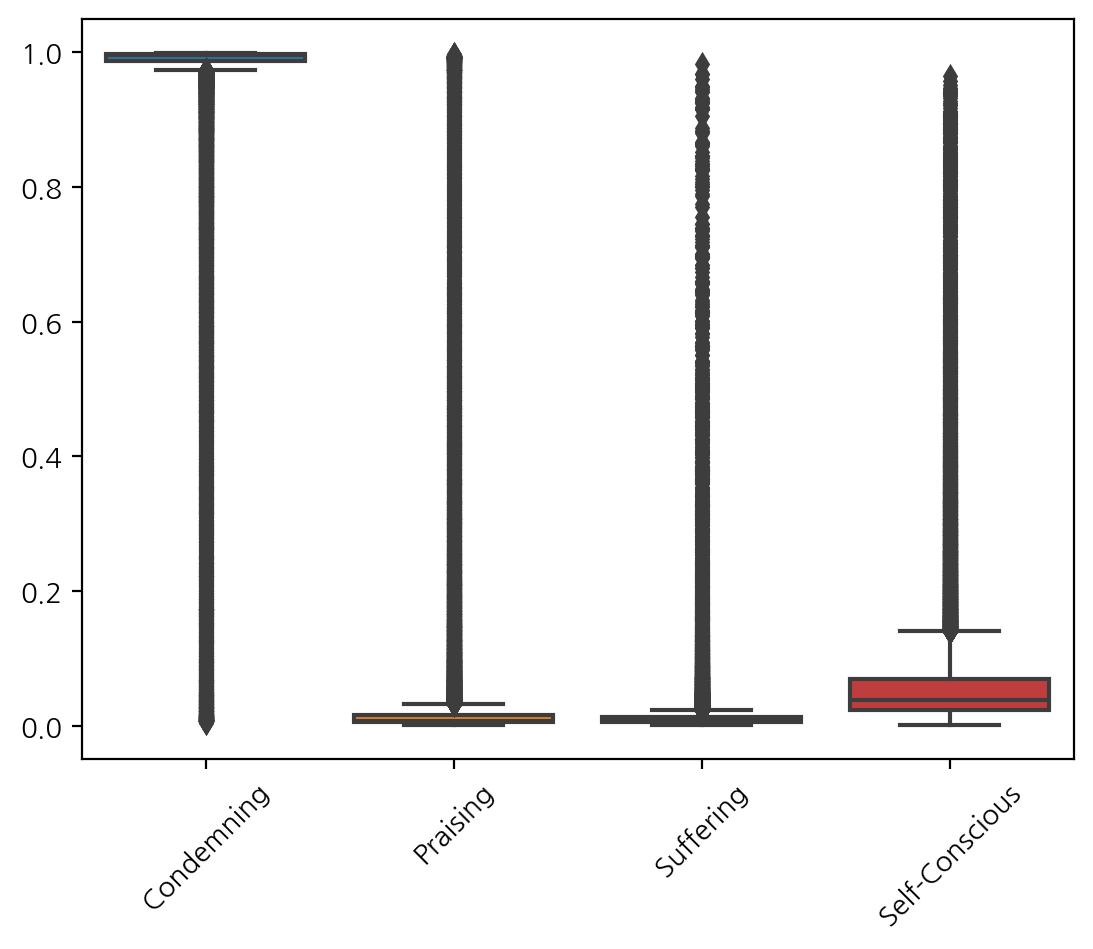

In [ ]:
g = sns.boxplot(data = df[['Condemning', 'Praising', 'Suffering','Self-Conscious']])
g.set_xticklabels(g.get_xticklabels(), rotation=45)

In [ ]:
# Define a function to perform the Kruskal-Wallis H test for the dependent variable based on the specified group column
def perform_kruskal_test_single(df, group_column, dependent_var):
    groups = [df[dependent_var][df[group_column] == group].values for group in df[group_column].unique() if group == group]  # Exclude NaN groups
    h_stat, p_val = kruskal(*groups)
    return h_stat, p_val

# Perform the Kruskal-Wallis H test based on 'user_type', 'title_p/n', and 'e_policy_p/n' for 'Condemning' and store the results
kruskal_results_single = {
    'user_type': perform_kruskal_test_single(df, 'user_type', 'Condemning'),
    'title_p/n': perform_kruskal_test_single(df, 'title_p/n', 'Condemning'),
    'e_policy_p/n': perform_kruskal_test_single(df, 'e_policy_p/n', 'Condemning')
}

kruskal_results_single

{'user_type': (1.0369445727936584, 0.30853314967972884),
 'title_p/n': (104.15528033767248, 2.415284220980935e-23),
 'e_policy_p/n': (1.7281880675245762, 0.42143318396478857)}

In [ ]:
df.groupby('title_p/n')['Condemning'].describe()

,count,mean,std,min,25%,50%,75%,max
title_p/n,,,,,,,,
Negative,34255.0,0.944062,0.170728,0.004469,0.988974,0.995871,0.997191,0.999108
Neutral,12502.0,0.935205,0.183066,0.004847,0.985887,0.995772,0.997217,0.999018
Positive,4229.0,0.910104,0.227859,0.004860,0.977628,0.995182,0.997013,0.998919
